In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import pickle as pkl

from scipy.stats import ttest_ind
from sklearn.preprocessing import RobustScaler
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture

font= matplotlib.font_manager.FontProperties(fname= 'C:\Windows\\Fonts\\조선일보명조.ttf').get_name()
matplotlib.rc('font', family=font)  

### 데이터를 로드하고 분석에 적합한 형태로 변환함

In [2]:
df_bymonth= pd.read_csv('./Pre_processed_data/groupby_ID_YEARMONTH.csv')

In [3]:
pt_bytsne= pd.read_pickle('./pkl_result/data_tSNE_dim2_perplex30.pkl')

In [4]:
df_raw= pd.read_csv('./Pre_processed_data/merged_dataframe_shopping.csv', delimiter= ',', encoding= 'euc-kr')

In [5]:
df_grouped= df_raw.sort_values('ID')

In [6]:
agg_func= {'RCT_NO': 'count', 'BIZ_UNIT': lambda x: x.nunique(), 'PD_S_C': lambda x: x.nunique(), \
           'BR_C': lambda x: x.nunique(), 'BUY_AM': 'sum'}

In [7]:
df_grouped= df_grouped.groupby('ID').agg(agg_func).reset_index(drop= False)

In [8]:
df_demo= df_raw[['ID', 'AGE_PRD', 'IS_MALE', 'IS_FEMALE', 'PRVIN']].drop_duplicates(subset= 'ID').sort_values('ID').reset_index(drop= True)

In [9]:
df_byitem= pd.read_pickle('./pkl_result/item_selected_by_middleline.pkl')

In [10]:
df_byitem= df_byitem.reset_index(drop=False)

In [11]:
df_item_consumed= pd.read_pickle('./pkl_result/item_selected_by_middleline.pkl')

In [12]:
df_item_consumed.reset_index(drop= False, inplace= True)

In [13]:
def plot_results(X, Y_= None):
    try:
        if Y_.any():
            for i in range(Y_.nunique()):
                grp= sns.regplot(x= X.loc[Y_==i, 0], y= X.loc[Y_==i, 1], fit_reg= False, scatter_kws= {'s': 2})
        plt.show()
    except AttributeError:
        grp= sns.regplot(x= X.iloc[:,0], y= X.iloc[:, 1], fit_reg= False, scatter_kws= {'s': 2})
        plt.show()

In [14]:
def plot_clusters(X, Y_):
    for i in sorted(Y_.unique().tolist()):
        grp= sns.regplot(x= X.iloc[:,0], y= X.iloc[:, 1], fit_reg= False, scatter_kws= {'s': 2})
        grp= sns.regplot(x= X.loc[Y_==i, 0], y= X.loc[Y_==i, 1], fit_reg= False, scatter_kws= {"color": "red", 's': 2})
        plt.show()

In [15]:
prefered_item_dict_05= {}
ft_dict= {}
def find_prefered_item(df, label, p_val= 0.05):
    for i in sorted(label.unique().tolist()):
        ft_dict[i]= df.loc[label==i, :]
        print('\nfor cluster {}:\n'.format(str(i)))
        prefered_item_dict_05[i]= []
        for item in df.columns.values.tolist():
            (stat_item, p_val_item)=  ttest_ind(ft_dict[i][item], df[item], equal_var= False)
            if p_val_item< p_val and stat_item>0:
                print('item {} has different mean with total dataset; ({}, {})'.format(item, stat_item, p_val_item))
                prefered_item_dict_05[i].append(item)
                
def find_prefered_by_clusters(df, label, i, j, p_val= 0.05):
    for item in df.columns.values.tolist():
        (stat_item, p_val_item)=  ttest_ind(df.loc[label==i, item], df.loc[label==j, item], equal_var= False)
        if p_val_item< p_val:
            print('item {} has different mean with total dataset; ({}, {})'.format(item, stat_item, p_val_item))

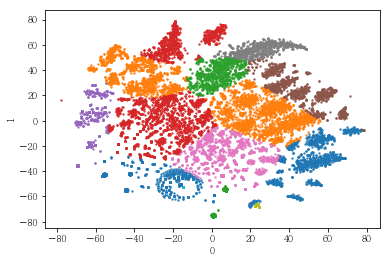

In [16]:
plot_results(pt_bytsne[[0,1]], pt_bytsne['y_14_clst'])

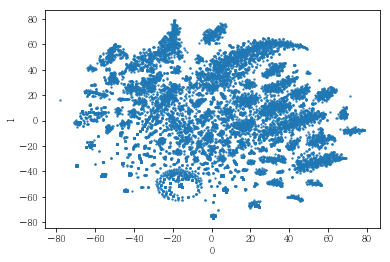

In [17]:
plot_results(pt_bytsne[[0,1]])

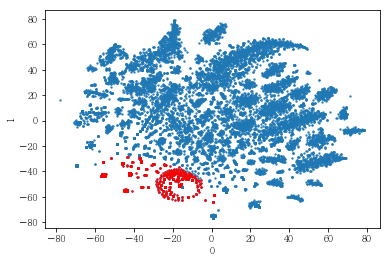

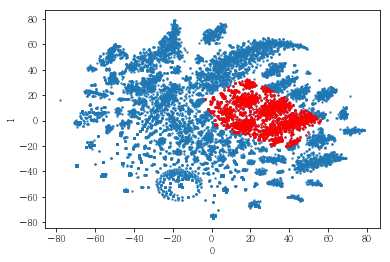

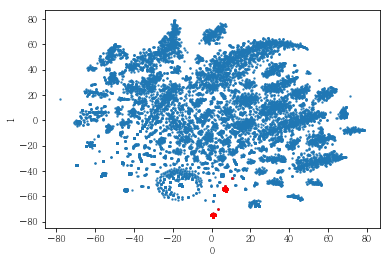

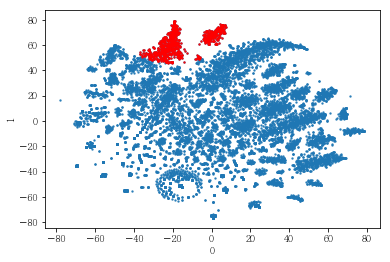

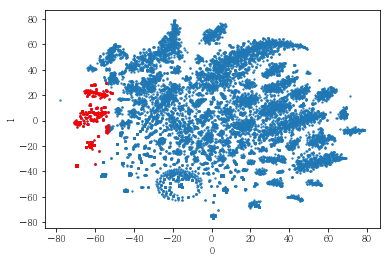

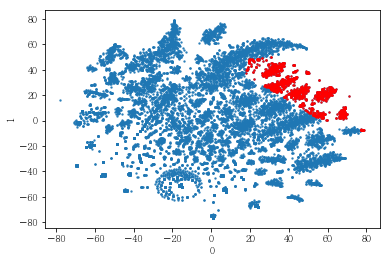

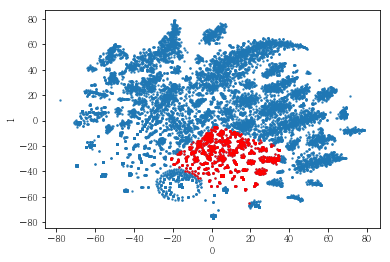

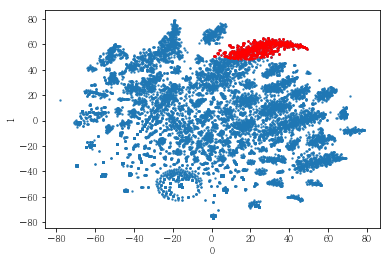

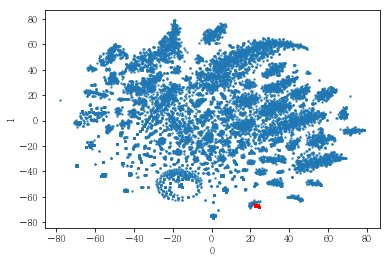

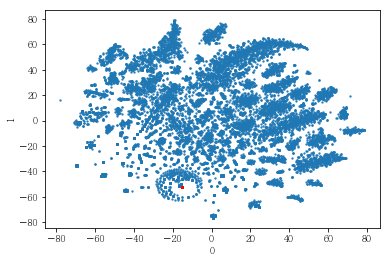

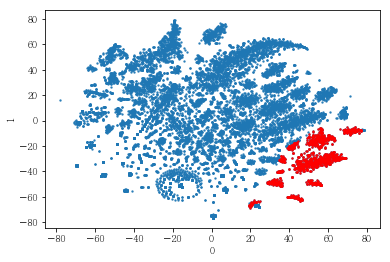

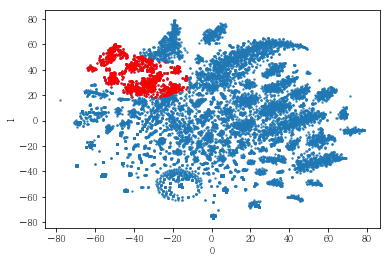

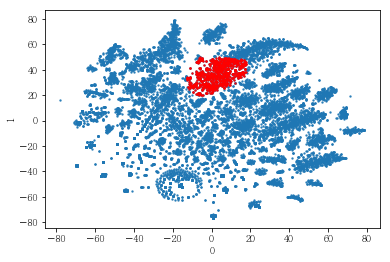

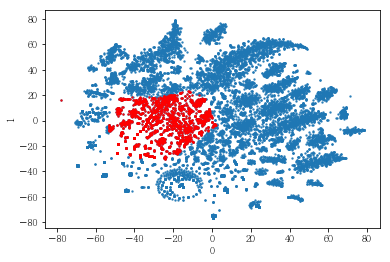

In [18]:
plot_clusters(pt_bytsne[[0,1]], pt_bytsne['y_14_clst'])

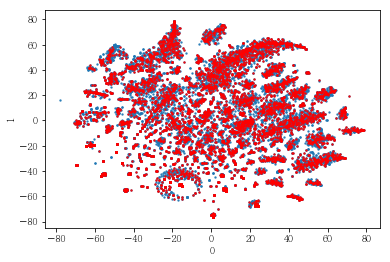

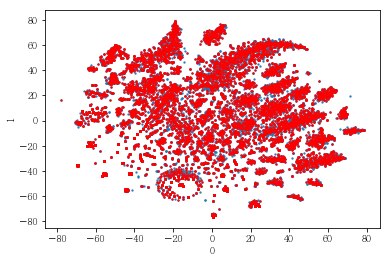

In [19]:
plot_clusters(pt_bytsne[[0,1]], df_demo['IS_FEMALE'])
#성별이 클러스터와 연관이 있는 인구통계 정보인지 확인함. 아래의 시각화 결과에 따르면, 성별은 클러스터를 구분짓는 요소는 아니지만 클러스터 내에서 소비 품목의 차이는 드러났음.

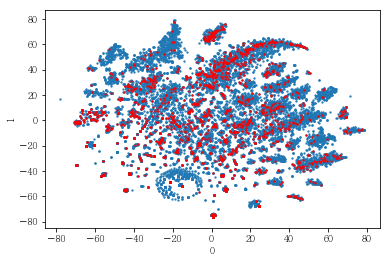

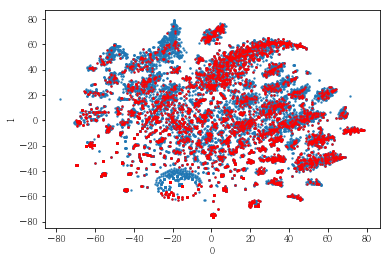

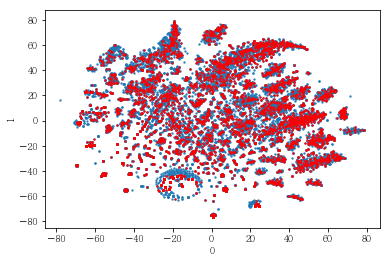

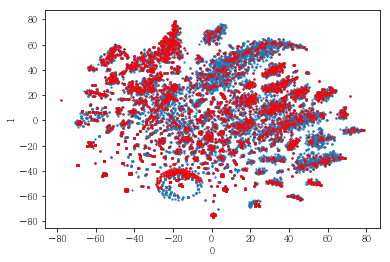

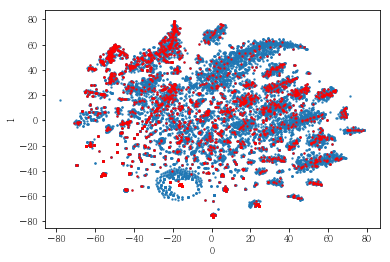

In [20]:
plot_clusters(pt_bytsne[[0,1]], df_demo['AGE_PRD'])
# 연령대의 경우도 마찬가지로 연령대와 관계 없이 폭넓게 분포하고 있었음.

### 성별, 연령대 또는 나이에 따라 사용자를 나누어 클러스터링해 보았음. 아래는 여성 사용자만을 대상으로 클러스터링한 결과임

In [21]:
pt_bytsne= pd.concat([df_demo['ID'], pt_bytsne], axis= 1)

In [22]:
pt_female= pt_bytsne.loc[df_demo['IS_FEMALE']==1, :].reset_index(drop= True)

In [23]:
pt_female.head()

ID          0          1  y_14_clst  y_28_clst  y_24_clst
0   2  53.016911 -32.975819         10          8          8
1   3 -22.183092  52.640892          3          9          9
2   6  42.187847  32.573856          5         17         17
3   7 -27.630230  52.580269          3         12         12
4   8  -5.850988  27.713455         12          3          3

In [24]:
pt_male= pt_bytsne.loc[df_demo['IS_FEMALE']==0, :].reset_index(drop= True)

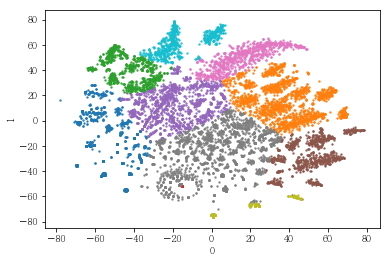

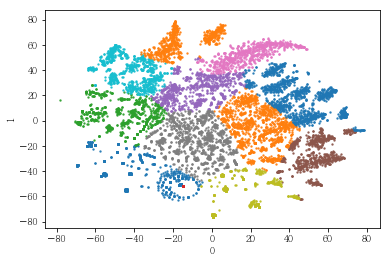

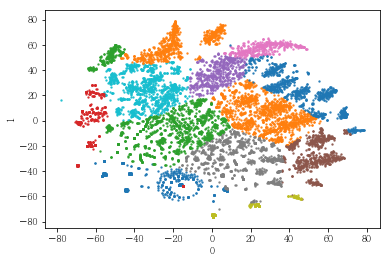

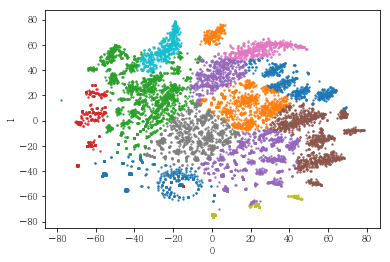

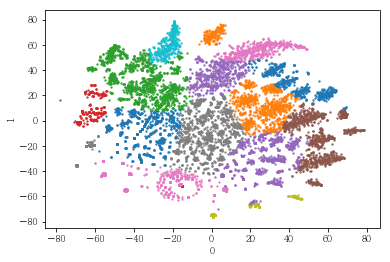

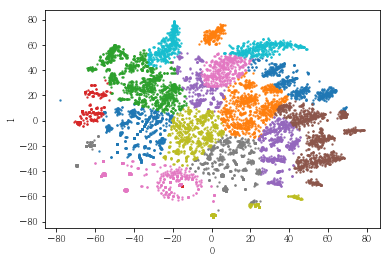

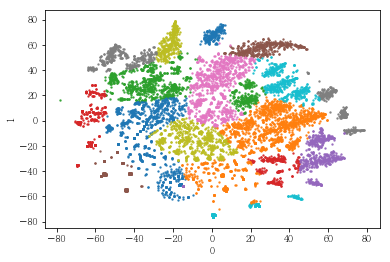

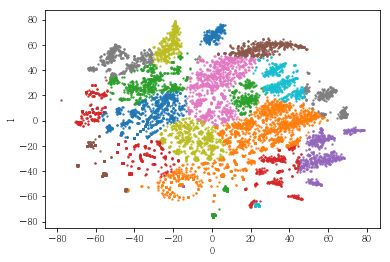

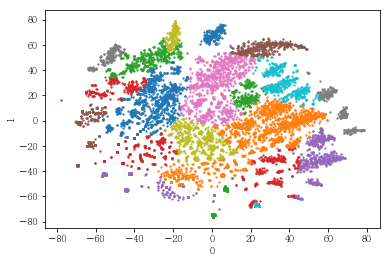

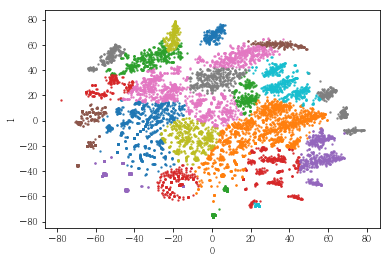

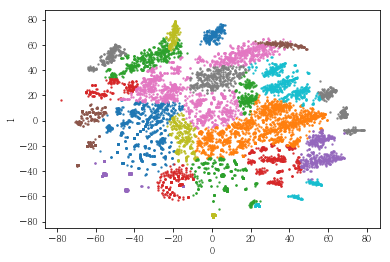

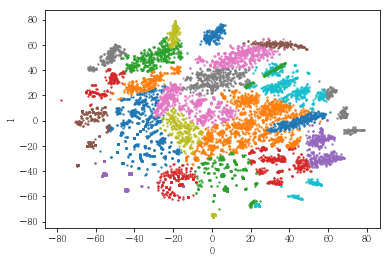

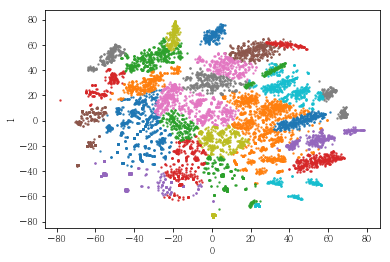

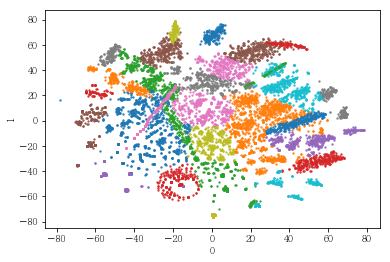

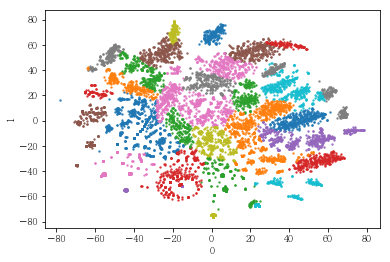

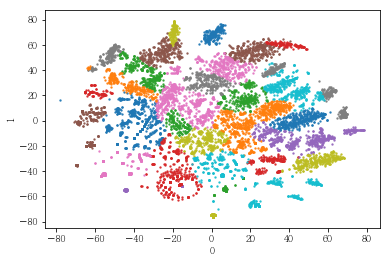

In [25]:
label_dict= {}
for i in range(10, 41, 2):
    gmm = GaussianMixture(n_components=i, covariance_type='full', random_state= 42).fit(pt_female[[0,1]])
    label_dict[(2,i)]= pd.Series(gmm.predict(pt_female[[0,1]]))
    plot_results(pt_female[[0,1]], label_dict[(2,i)])

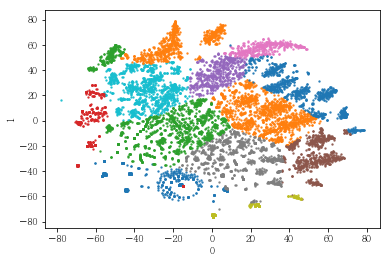

In [26]:
gmm = GaussianMixture(n_components=14, covariance_type='full', random_state= 42).fit(pt_female[[0,1]])
label_dict[(2,i)]= pd.Series(gmm.predict(pt_female[[0,1]]))
plot_results(pt_female[[0,1]], label_dict[(2,14)])

# 여성들만을 군집화한 경우에도 유사한 클러스터가 형성되는 것을 확인함

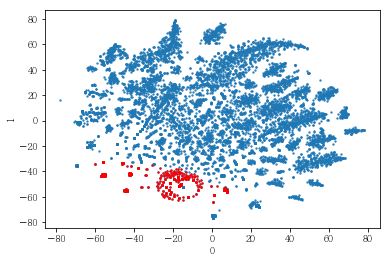

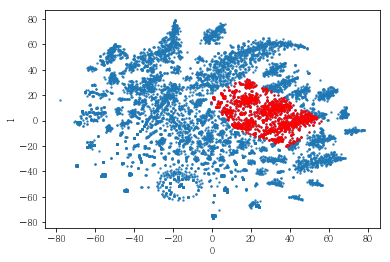

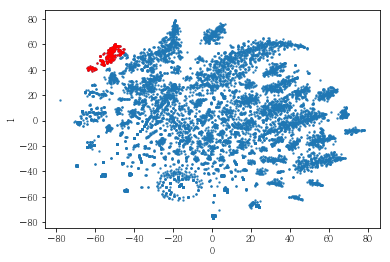

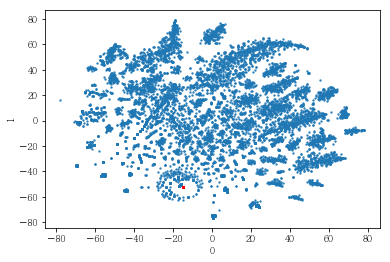

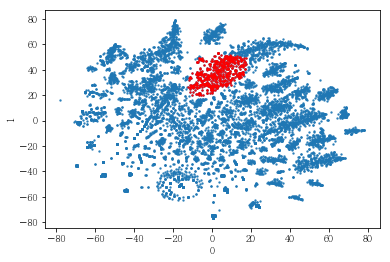

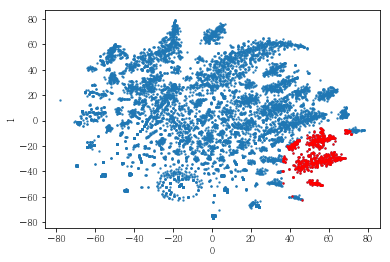

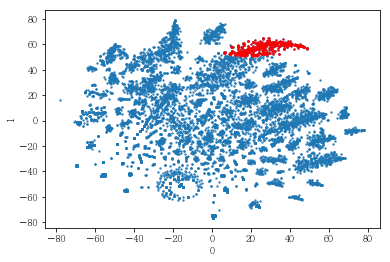

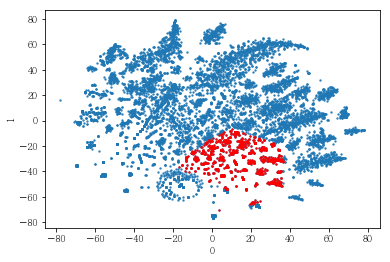

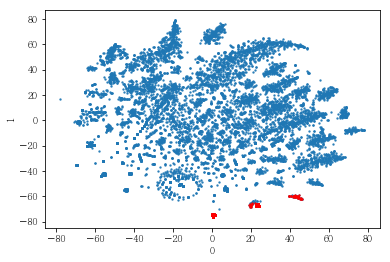

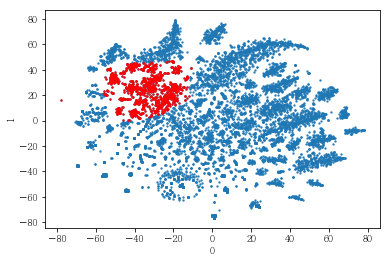

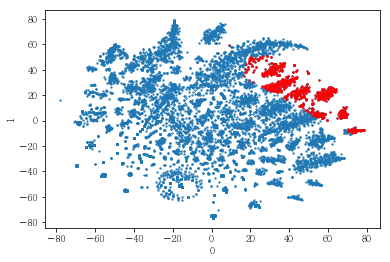

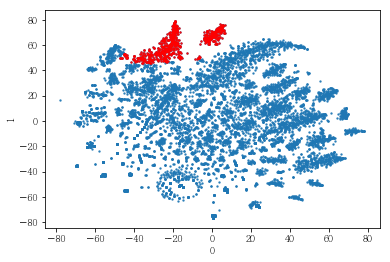

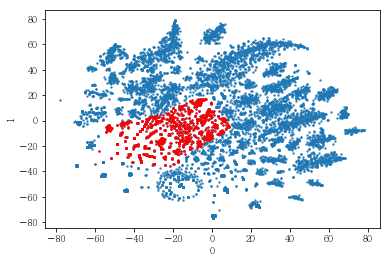

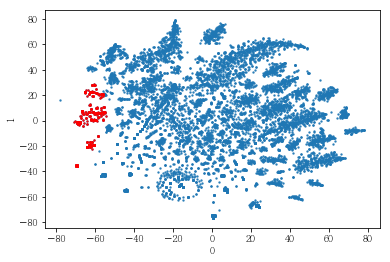

In [27]:
plot_clusters(pt_female[[0,1]], label_dict[(2,14)])

In [28]:
df_female= df_item_consumed.loc[df_demo['IS_FEMALE']==1, :].drop('ID', axis= 1).reset_index(drop= True)

In [29]:
df_female.head()

H&B선물세트  VIDEOGAME  가공식품  가공우유   가구  가방브랜드  계절완구   고급  고양이용품   골프  ...    \
0      0.0        0.0   6.0   1.0  0.0    0.0   0.0  0.0    0.0  0.0  ...     
1      0.0        0.0   3.0   0.0  0.0    0.0   0.0  0.0    0.0  0.0  ...     
2      0.0        0.0   2.0   0.0  0.0    0.0   0.0  0.0    0.0  0.0  ...     
3      0.0        0.0  18.0   0.0  0.0    0.0   0.0  0.0    0.0  0.0  ...     
4      0.0        0.0  23.0   2.0  0.0    0.0   0.0  0.0    0.0  0.0  ...     

   필기용품  한방차  한우선물세트   해초  헬스용품  호주산소고기  홍인삼  화과자   황태  훼이셜케어  
0   0.0  0.0     0.0  0.0   0.0     0.0  0.0  0.0  0.0    0.0  
1   0.0  0.0     0.0  0.0   0.0     4.0  0.0  0.0  0.0    0.0  
2   0.0  0.0     0.0  0.0   0.0    14.0  0.0  1.0  0.0    0.0  
3   0.0  0.0     0.0  0.0   0.0     0.0  0.0  0.0  0.0    0.0  
4   0.0  0.0     0.0  0.0   0.0     0.0  0.0  0.0  0.0    0.0  

[5 rows x 149 columns]

In [30]:
find_prefered_item(df_female, label_dict[(2,14)])


for cluster 0:


for cluster 1:

item 고양이용품 has different mean with total dataset; (3.299518677371703, 0.0009909005140444082)
item 골프 has different mean with total dataset; (2.2027005968132984, 0.027740297838069142)
item 기능성건강 has different mean with total dataset; (3.4992108669368958, 0.0004793779071884237)
item 남성어덜트캐주얼 has different mean with total dataset; (2.0028544157994808, 0.04534364652717147)
item 석류 has different mean with total dataset; (2.090670045665515, 0.03670272271987567)
item 스낵 has different mean with total dataset; (16.74676631306228, 1.558399904946653e-58)
item 스포츠슈즈 has different mean with total dataset; (1.9651539914316039, 0.04955514830267115)
item 시즌행사 has different mean with total dataset; (3.277927144713126, 0.0010671906320496205)
item 시티캐주얼 has different mean with total dataset; (3.26787436537591, 0.0011070949867525788)
item 언더웨어행사 has different mean with total dataset; (2.1998402667187427, 0.027943694964898326)
item 여성양말 has different mean with total datase

item 푸드코트 has different mean with total dataset; (13.291866607767933, 1.5532551958740325e-36)
item 헬스용품 has different mean with total dataset; (2.0774775063512476, 0.03805282813787264)
item 홍인삼 has different mean with total dataset; (2.2437765465853268, 0.02510429246746001)
item 황태 has different mean with total dataset; (2.6692733172703442, 0.0077491241466846805)

for cluster 6:

item H&B선물세트 has different mean with total dataset; (2.19468540966767, 0.028696471663472816)
item 가공식품 has different mean with total dataset; (8.896651243111338, 1.255737125736185e-17)
item 가공우유 has different mean with total dataset; (18.462679372883937, 8.064887538563822e-57)
item 계절완구 has different mean with total dataset; (2.305311501744621, 0.021611523046977124)
item 고급 has different mean with total dataset; (4.070322543613183, 5.558716533108937e-05)
item 과일야채 has different mean with total dataset; (2.9194502193580956, 0.003681355848781106)
item 구기용품 has different mean with total dataset; (2.57569487952445

item 주니어양말 has different mean with total dataset; (2.9358670495445724, 0.0033979724422648905)
item 준보석 has different mean with total dataset; (3.888234574377179, 0.00010733507121506645)
item 즉석구이김 has different mean with total dataset; (4.378971965702216, 1.3117886891385495e-05)
item 즉석구이안주 has different mean with total dataset; (3.6861321873398154, 0.00023893607234442445)
item 즉석도정미 has different mean with total dataset; (4.594323132519724, 4.864887731845669e-06)
item 차 has different mean with total dataset; (7.618326112057484, 5.6590122880599855e-14)
item 천연조미료 has different mean with total dataset; (2.9515694520376714, 0.0032272697070919506)
item 캐주얼슈즈 has different mean with total dataset; (2.365537012943426, 0.01817790948681538)
item 캠핑 has different mean with total dataset; (2.7848206598219964, 0.005451281817607978)
item 커피선물세트 has different mean with total dataset; (2.328916913422505, 0.020047424352357863)
item 튀김 has different mean with total dataset; (8.677521363361915, 1.5523

### 남성 사용자를 클러스터링해 보았음. 이 때 6번 클러스터와 7번 클러스터 간의 차이를 파악하였음.

In [31]:
pt_male= pt_bytsne.loc[df_demo['IS_FEMALE']==0, :].reset_index(drop= True)
df_male= df_item_consumed.loc[df_demo['IS_FEMALE']==0, :].drop('ID', axis= 1).reset_index(drop= True)
id_male= df_raw.loc[df_raw['IS_MALE']==1, 'ID'].drop_duplicates().sort_values().reset_index(drop= True)
df_demo_male= df_demo.loc[df_demo['ID'].isin(id_male), :].reset_index(drop= True)
df_male.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7003 entries, 0 to 7002
Columns: 149 entries, H&B선물세트 to 훼이셜케어
dtypes: float64(149)
memory usage: 8.0 MB


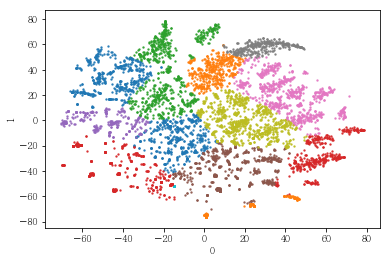

In [32]:
gmm = GaussianMixture(n_components=14, covariance_type='full', random_state= 42).fit(pt_male[[0,1]])
label_dict[(2, 14)]= pd.Series(gmm.predict(pt_male[[0,1]]))
plot_results(pt_male[[0,1]], label_dict[(2,14)])

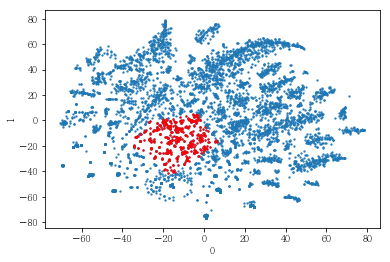

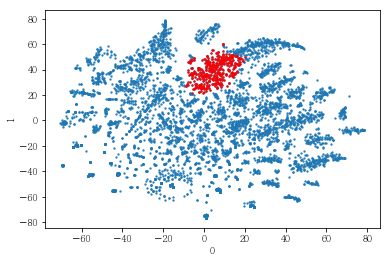

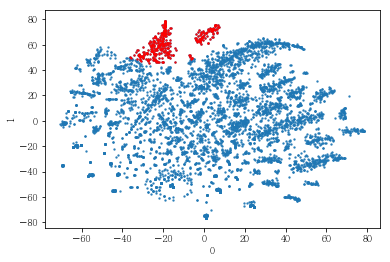

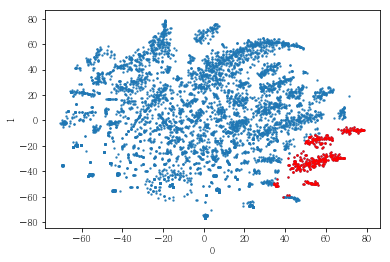

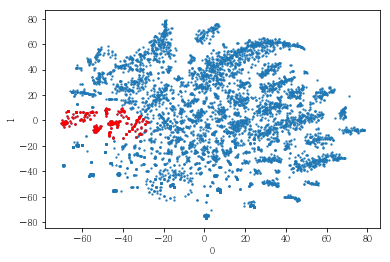

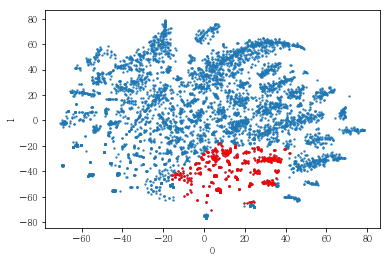

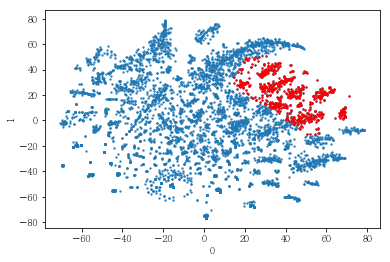

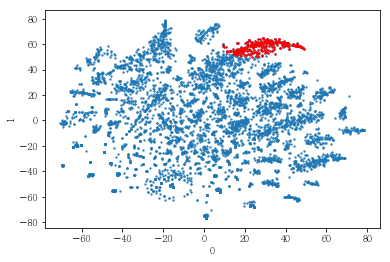

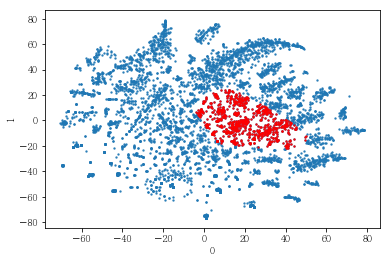

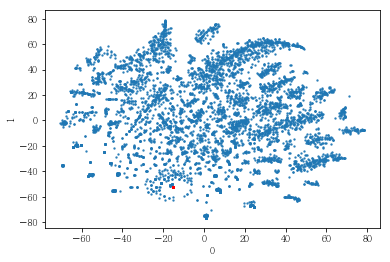

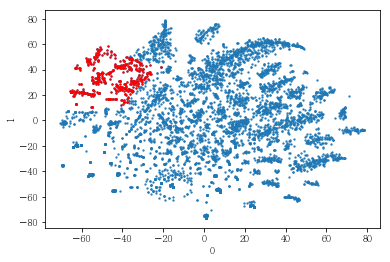

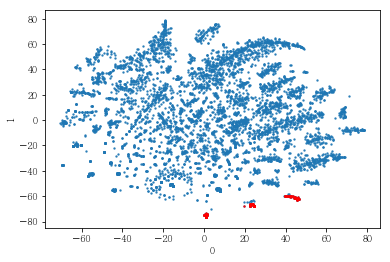

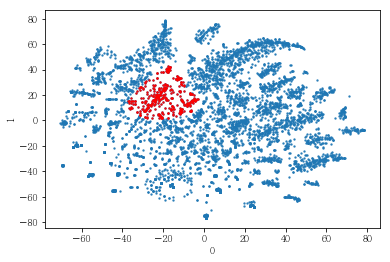

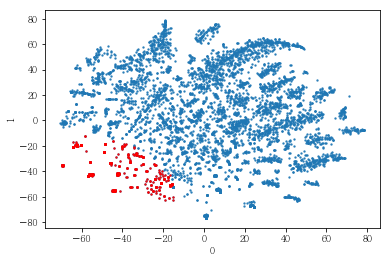

In [33]:
plot_clusters(pt_male[[0,1]], label_dict[(2,14)])

In [34]:
find_prefered_item(df_male, label_dict[(2,14)])


for cluster 0:

item 탈취제 has different mean with total dataset; (2.0419680352992704, 0.04160079302594415)
item 훼이셜케어 has different mean with total dataset; (2.3323599388324268, 0.02004032386316317)

for cluster 1:

item 가공식품 has different mean with total dataset; (2.913083654507895, 0.003709770570241837)
item 가공우유 has different mean with total dataset; (15.67551936206713, 1.0153405456487646e-51)
item 봉투보증금 has different mean with total dataset; (3.9168124709859797, 0.00010124557716052506)

for cluster 2:

item 가공식품 has different mean with total dataset; (10.704918560775756, 1.373045410334679e-23)
item 골프용품 has different mean with total dataset; (14.321693222971092, 2.474838088644525e-37)
item 과자 has different mean with total dataset; (5.273221169296936, 2.2872819634808253e-07)
item 남성정장 has different mean with total dataset; (6.882567205683728, 2.4693290119539018e-11)
item 남성케어 has different mean with total dataset; (2.552784613110995, 0.011082423476798399)
item 대형가전 has different mea

item 식사류 has different mean with total dataset; (4.5365793171348665, 6.567365255774932e-06)
item 식자재 has different mean with total dataset; (2.002240032953679, 0.045580708061196074)
item 아동브랜드 has different mean with total dataset; (2.600234874026553, 0.009442276428687814)
item 아로마 has different mean with total dataset; (3.0615985587200307, 0.0022669327049412145)
item 애견용품 has different mean with total dataset; (7.395603690605324, 3.465284854742817e-13)
item 언더웨어행사 has different mean with total dataset; (3.586937639050662, 0.0003531972502871889)
item 여성양말 has different mean with total dataset; (3.572212193852571, 0.00037399697271913574)
item 여성캐주얼브랜드 has different mean with total dataset; (3.412037053165797, 0.0006721019782997301)
item 우산/양산 has different mean with total dataset; (1.995218598491354, 0.04633775314333988)
item 원예용품 has different mean with total dataset; (3.830427493377676, 0.00013679508968591166)
item 유가공 has different mean with total dataset; (5.879772533795735, 5.71450

item 일반헤어케어 has different mean with total dataset; (2.2792073570801565, 0.02286385500667511)
item 자몽 has different mean with total dataset; (2.1902177248790307, 0.02874627529474243)
item 차 has different mean with total dataset; (2.6417537177590176, 0.008370095594126995)
item 튀김 has different mean with total dataset; (7.864295226420433, 8.610441467994911e-15)
item 피자 has different mean with total dataset; (2.6481992536971513, 0.008229719576294935)

for cluster 9:


for cluster 10:

item 골프용품 has different mean with total dataset; (5.364397805375737, 1.0109384395342842e-07)
item 남성정장 has different mean with total dataset; (6.931738303901187, 1.2026648168810738e-11)
item 시티웨어 has different mean with total dataset; (6.603368654166181, 9.568697426503048e-11)
item 피혁잡화 has different mean with total dataset; (10.254218381494848, 1.160777653095967e-22)

for cluster 11:

item 주유소 has different mean with total dataset; (5.19868293618637, 4.154161480839718e-07)

for cluster 12:

item 가공식품 has dif

In [35]:
find_prefered_by_clusters(df_male, label_dict[(2, 14)], 6, 7)

item 가공식품 has different mean with total dataset; (-5.832776731086528, 9.253239253375856e-09)
item 가공우유 has different mean with total dataset; (-19.444665082544372, 8.563636933160878e-58)
item 가방브랜드 has different mean with total dataset; (3.194662174154414, 0.0014448165350527367)
item 계절완구 has different mean with total dataset; (-2.4690126769472807, 0.01401974842473204)
item 고급 has different mean with total dataset; (-2.415875717541854, 0.016207801012808824)
item 과일야채 has different mean with total dataset; (-4.4200640098135855, 1.2666329490414027e-05)
item 남성어덜트캐주얼 has different mean with total dataset; (2.1638115635387876, 0.030692726084018334)
item 너트류 has different mean with total dataset; (-3.872620362067213, 0.00012820677393496233)
item 동물병원 has different mean with total dataset; (2.093468473211416, 0.036618722349524485)
item 드레스화브랜드 has different mean with total dataset; (2.328347974089112, 0.02008021487621238)
item 롤샌드/핫도그 has different mean with total dataset; (-2.63948887400181

In [36]:
df_byitem.loc[df_demo['IS_MALE']==1].reset_index().loc[label_dict[(2,14)]==6, :].head()

index  ID  H&B선물세트  VIDEOGAME  가공식품  가공우유   가구  가방브랜드  계절완구   고급  ...    \
1       3   4      0.0        0.0  38.0   0.0  0.0    0.0   0.0  0.0  ...     
12     26  29      0.0        0.0  11.0   0.0  0.0    0.0   0.0  0.0  ...     
19     39  42      0.0        0.0  22.0   0.0  0.0    0.0   0.0  0.0  ...     
22     46  50      0.0        0.0   9.0   2.0  0.0    0.0   0.0  0.0  ...     
26     52  56      0.0        0.0  13.0   0.0  0.0    0.0   0.0  0.0  ...     

    필기용품  한방차  한우선물세트   해초  헬스용품  호주산소고기   홍인삼  화과자   황태  훼이셜케어  
1    0.0  0.0     0.0  0.0   0.0     0.0   0.0  0.0  0.0    0.0  
12   0.0  0.0     0.0  0.0   0.0     9.0   0.0  0.0  4.0    1.0  
19   0.0  3.0     0.0  0.0   3.0     0.0   0.0  0.0  1.0    1.0  
22   0.0  1.0     0.0  1.0   0.0    15.0  14.0  0.0  0.0    0.0  
26   0.0  0.0     0.0  1.0   0.0     0.0   0.0  0.0  0.0    0.0  

[5 rows x 151 columns]

#### 6번 클러스터와 7번 클러스터 간의 지표 차이를 파악하였음.

In [37]:
df_clst6= df_demo_male.loc[label_dict[(2,14)]==6, :]

In [38]:
df_clst7= df_demo_male.loc[label_dict[(2,14)]==7, :]

In [39]:
df_info6= df_grouped.loc[df_grouped['ID'].isin(df_clst6['ID']), :]
df_info7= df_grouped.loc[df_grouped['ID'].isin(df_clst7['ID']), :]

In [40]:
df_info6.head()

ID  RCT_NO  BIZ_UNIT  PD_S_C  BR_C    BUY_AM
3    4     308         3     136     7   7970116
26  29     408         2     159     5   3756730
39  42     492         2     138     3   5425186
46  50     566         3     238    11  10626666
52  56     107         3      58     6   2197496

In [41]:
df_clst6.AGE_PRD.value_counts().sort_index()

20     55
30    156
40    249
50    212
60    129
Name: AGE_PRD, dtype: int64

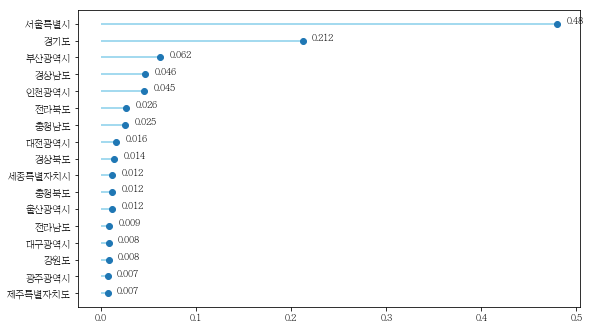

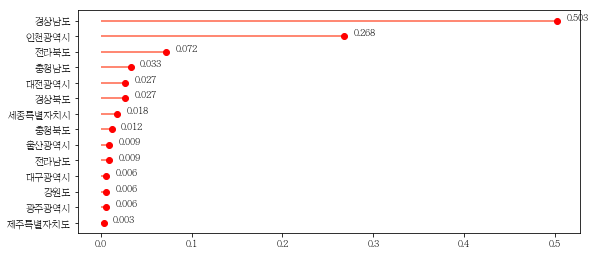

In [42]:
df_value6= df_clst6.PRVIN.value_counts().sort_values()
df_value7= df_clst7.PRVIN.value_counts().sort_values()
df_ratio6= (df_value6/df_clst6.PRVIN.count()).apply(lambda x: round(x, 3))
df_ratio7= (df_value7/df_clst7.PRVIN.count()).apply(lambda x: round(x, 3))

num_of_range= range(1, df_value6.count()+1)
grp= plt.figure(figsize= (9,12))
ax= grp.add_subplot(211)
plt.hlines(y=num_of_range, xmin=0, xmax=df_ratio6, color='skyblue')
for i in num_of_range:
    ax.annotate(df_ratio6.values.tolist()[i-1], xy=(df_ratio6.values.tolist()[i-1]+0.01, i+0.01), textcoords='data')
plt.plot(df_ratio6, num_of_range, "o")
plt.yticks(num_of_range, df_value6.index)

num_of_range= range(1, df_value7.count()+1)
grp= plt.figure(figsize= (9,9))
ax= grp.add_subplot(212)
plt.hlines(y=num_of_range, xmin=0, xmax=df_ratio7, color='tomato')
for i in num_of_range:
    ax.annotate(df_ratio7.values.tolist()[i-1], xy=(df_ratio7.values.tolist()[i-1]+0.01, i+0.01), textcoords='data')
plt.plot(df_ratio7, num_of_range, "o", color= 'red')
plt.yticks(num_of_range, df_value6.index)
plt.show()

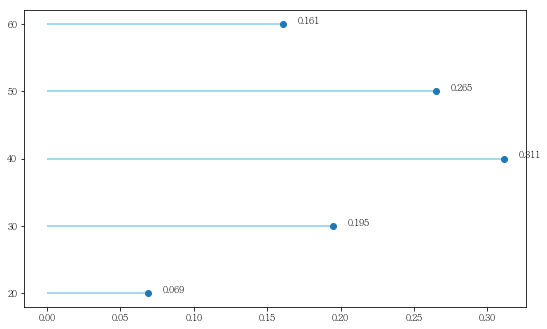

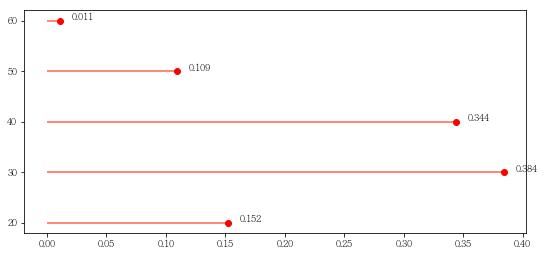

In [43]:
df_value6= df_clst6.AGE_PRD.value_counts().sort_index()
df_value7= df_clst7.AGE_PRD.value_counts().sort_index()
df_ratio6= (df_value6/df_clst6.AGE_PRD.count()).apply(lambda x: round(x, 3))
df_ratio7= (df_value7/df_clst7.AGE_PRD.count()).apply(lambda x: round(x, 3))

num_of_range= range(1, df_value6.count()+1)
grp= plt.figure(figsize= (9,12))
ax= grp.add_subplot(211)
plt.hlines(y=num_of_range, xmin=0, xmax=df_ratio6, color='skyblue')
for i in num_of_range:
    ax.annotate(df_ratio6.values.tolist()[i-1], xy=(df_ratio6.values.tolist()[i-1]+0.01, i+0.01), textcoords='data')
plt.plot(df_ratio6, num_of_range, "o")
plt.yticks(num_of_range, df_value6.index)

num_of_range= range(1, df_value7.count()+1)
grp= plt.figure(figsize= (9,9))
ax= grp.add_subplot(212)
plt.hlines(y=num_of_range, xmin=0, xmax=df_ratio7, color='tomato')
for i in num_of_range:
    ax.annotate(df_ratio7.values.tolist()[i-1], xy=(df_ratio7.values.tolist()[i-1]+0.01, i+0.01), textcoords='data')
plt.plot(df_ratio7, num_of_range, "o", color= 'red')
plt.yticks(num_of_range, df_value6.index)
plt.show()

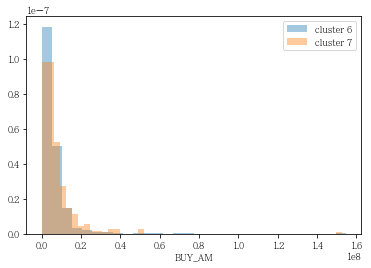

In [44]:
grp= sns.distplot(df_info6['BUY_AM'], label= 'cluster 6', bins= 30, kde= False, norm_hist= True)
grp= sns.distplot(df_info7['BUY_AM'], label= 'cluster 7', kde= False, norm_hist= True)
plt.legend()
plt.show()

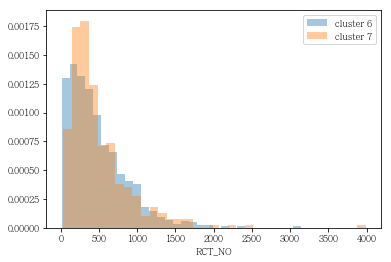

In [45]:
grp= sns.distplot(df_info6['RCT_NO'], label= 'cluster 6', bins= 30, kde= False, norm_hist= True)
grp= sns.distplot(df_info7['RCT_NO'], label= 'cluster 7', kde= False, norm_hist= True)
plt.legend()
plt.show()

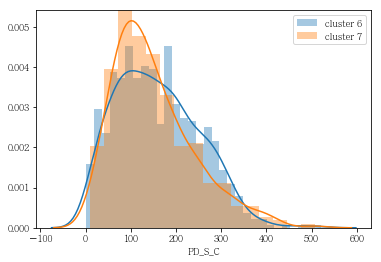

In [46]:
grp= sns.distplot(df_info6['PD_S_C'], label= 'cluster 6', bins= 30, kde= True)
grp= sns.distplot(df_info7['PD_S_C'], label= 'cluster 7', kde= True)
plt.legend()
plt.show()

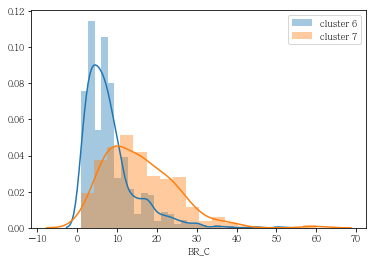

In [47]:
grp= sns.distplot(df_info6['BR_C'], label= 'cluster 6', bins= 30, kde= True)
grp= sns.distplot(df_info7['BR_C'], label= 'cluster 7', kde= True)
plt.legend()
plt.show()

### 20-40대 서울 거주 여성을 클러스터링함

In [48]:
pt_specified= pt_bytsne.loc[(df_demo['IS_FEMALE']==1)&((df_demo['AGE_PRD']==20)|(df_demo['AGE_PRD']==30)|(df_demo['AGE_PRD']==40))&(df_demo['PRVIN']=='서울특별시'), :].reset_index(drop= True)
df_specified= df_item_consumed.loc[(df_demo['IS_FEMALE']==1)&((df_demo['AGE_PRD']==20)|(df_demo['AGE_PRD']==30)|(df_demo['AGE_PRD']==40))&(df_demo['PRVIN']=='서울특별시'), :].drop('ID', axis= 1).reset_index(drop= True)
df_specified.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2554 entries, 0 to 2553
Columns: 149 entries, H&B선물세트 to 훼이셜케어
dtypes: float64(149)
memory usage: 2.9 MB


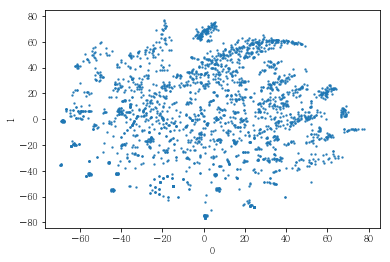

In [49]:
plot_results(pt_specified[[0,1]])

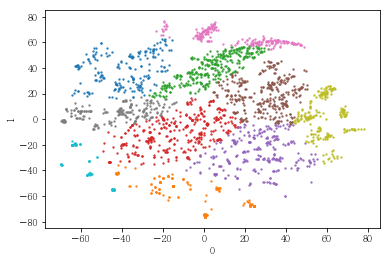

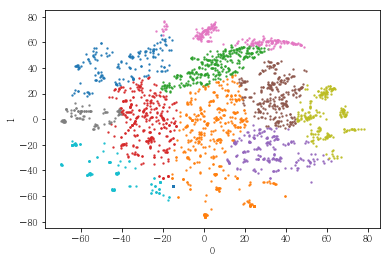

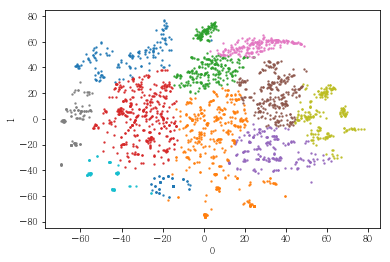

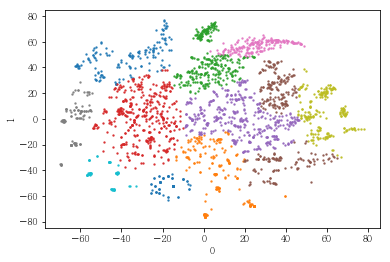

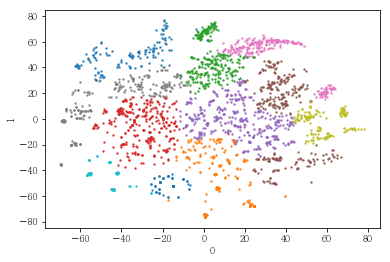

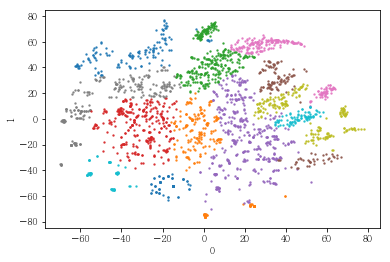

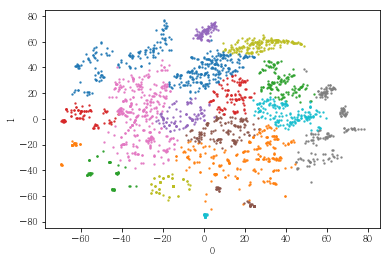

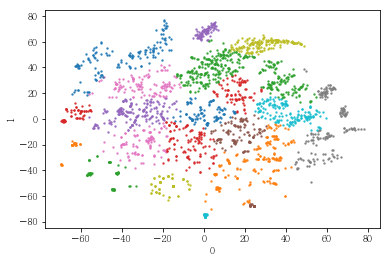

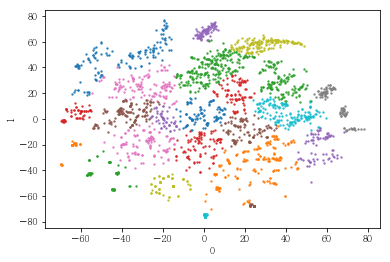

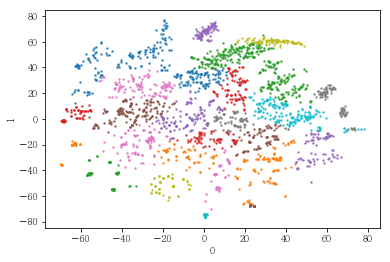

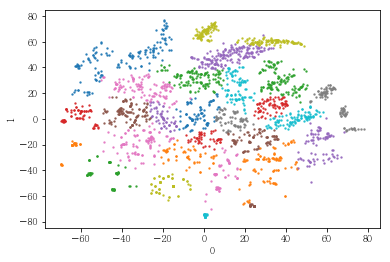

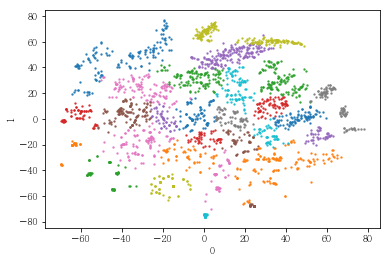

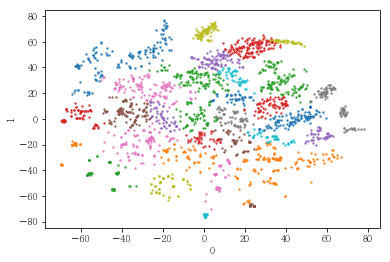

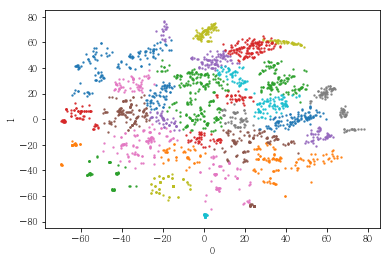

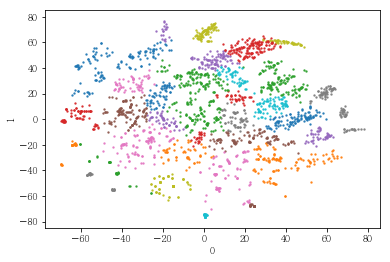

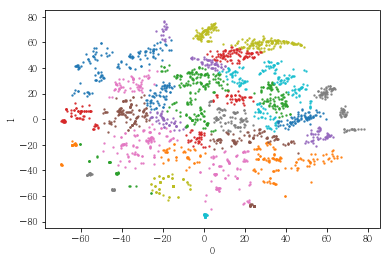

In [50]:
label_dict= {}
for i in range(10, 41, 2):
    gmm = GaussianMixture(n_components=i, covariance_type='full', random_state= 42).fit(pt_specified[[0,1]])
    label_dict[(2,i)]= pd.Series(gmm.predict(pt_specified[[0,1]]))
    plot_results(pt_specified[[0,1]], label_dict[(2,i)])

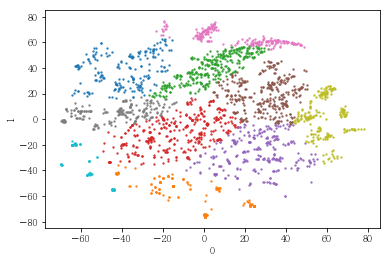

In [51]:
gmm = GaussianMixture(n_components=10, covariance_type='full', random_state= 42).fit(pt_specified[[0,1]])
label_dict[(2,i)]= pd.Series(gmm.predict(pt_specified[[0,1]]))
plot_results(pt_specified[[0,1]], label_dict[(2,10)])

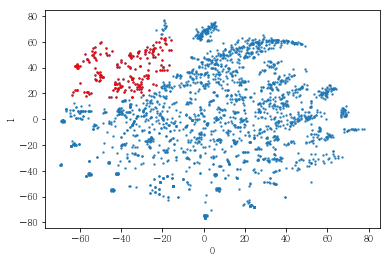

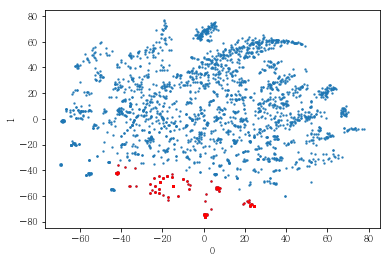

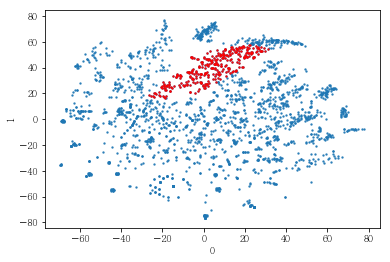

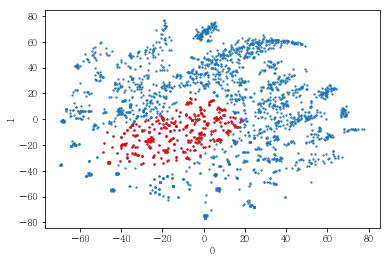

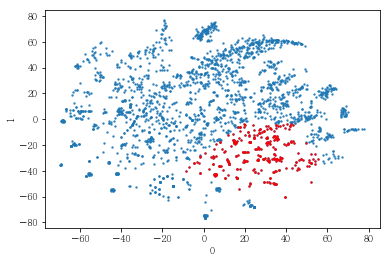

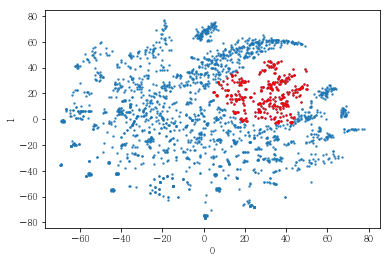

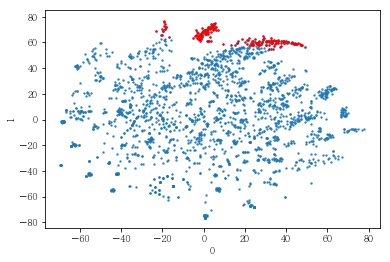

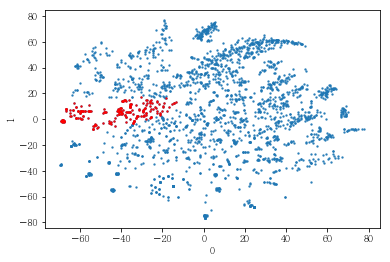

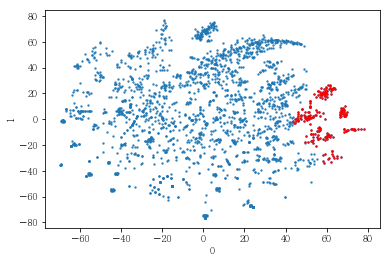

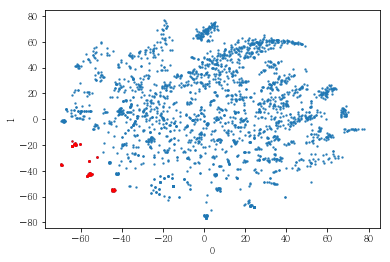

In [52]:
plot_clusters(pt_specified[[0,1]], label_dict[(2,10)])

In [53]:
find_prefered_item(df_specified, label_dict[(2,10)])


for cluster 0:

item 가공식품 has different mean with total dataset; (3.8085240588030733, 0.00017855907703891364)
item 골프용품 has different mean with total dataset; (7.747799521935178, 3.3028682686205725e-13)
item 남성정장 has different mean with total dataset; (3.7142440627692577, 0.00026118070718228573)
item 시티웨어 has different mean with total dataset; (3.396846555905115, 0.0008163765024180523)
item 피혁잡화 has different mean with total dataset; (7.46102150568361, 2.161620614550045e-12)

for cluster 1:


for cluster 2:

item 가공식품 has different mean with total dataset; (7.768563116556986, 8.632857365934452e-14)
item 가공우유 has different mean with total dataset; (10.932506203841688, 1.4418737628213408e-25)
item 고급 has different mean with total dataset; (3.6250139587881316, 0.0003328805841116394)
item 과일야채 has different mean with total dataset; (2.315532928404998, 0.021146692635860914)
item 너트류 has different mean with total dataset; (2.752705443325415, 0.0061647106949745635)
item 봉투보증금 has different m